In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
from sklearn import metrics, datasets


data = datasets.fetch_california_housing()

train_data = pd.DataFrame(data["data"], columns = data["feature_names"])
train_labels = data["target"]

train_pool = Pool(data=train_data,
                  label=train_labels)

cat_features = []

tree_step_size = 50
number_of_iterations = 100
number_of_trees = number_of_iterations * tree_step_size

first = True
boosted_predictions = np.zeros(len(train_labels))

mae_step = []
mae_increase = []
mae_increase_pool = []

for iteration in range(0, number_of_iterations):
    
    model = CatBoostRegressor(iterations = tree_step_size,
                               learning_rate = 0.5,
                               depth = 3,
                               silent = True)   
    
    model_pool = CatBoostRegressor(iterations = tree_step_size,
                                   learning_rate = 0.5,
                                   depth = 3,
                                   silent = True)
    
    if first:
        model.fit(train_data, train_labels, cat_features)
        first = False
    else:
        model.fit(train_data, train_labels, cat_features, baseline=boosted_predictions)
   
    model_pool.fit(train_pool)

    predictions_pool = model_pool.predict(train_pool)
    
    train_pool = Pool(
        data=train_data,
        label=train_labels,
        baseline=predictions_pool
    )
        
    predictions = model.predict(train_data)
    boosted_predictions += predictions
    
    mae_step.append(metrics.mean_absolute_error(train_labels, predictions))
    mae_increase.append(metrics.mean_absolute_error(train_labels, boosted_predictions))
    mae_increase_pool.append(metrics.mean_absolute_error(train_labels, predictions_pool))

step_predictions = boosted_predictions

model = CatBoostRegressor(iterations = number_of_trees,
                           learning_rate = 0.5,
                           depth = 3, 
                           silent = True) 

model.fit(train_data, train_labels, cat_features)
full_predictions = model.predict(train_data)

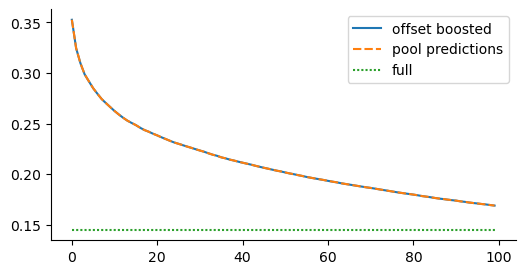

In [2]:
metrics_df = pd.DataFrame({
    "offset boosted": mae_increase,
    "pool predictions": mae_increase_pool,
    "full": metrics.mean_absolute_error(train_labels, full_predictions)
})


fig, ax = plt.subplots(figsize=(6, 3))

sns.lineplot(data=metrics_df)

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')